# Predicting Diatom concentration with functional regression based on the oceanographic boxes (spatial means)

## Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xskillscore as xs

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import r_regression

from skfda.representation.grid import FDataGrid
from skfda.ml.clustering import KMeans

from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix, LocalLinearRegressionHatMatrix, KNeighborsHatMatrix
from skfda.preprocessing.smoothing import KernelSmoother

from skfda.ml.regression import HistoricalLinearRegression

from sklearn.metrics import root_mean_squared_error as rmse

import os
import lzma
import dill

from tqdm import tqdm

import cmocean.cm as cm
import salishsea_tools.viz_tools as sa_vi

np.warnings.filterwarnings('ignore') # For the nan mean warning

from sklearn.utils import resample


## Datasets Preparation

In [2]:
# Creation of the training - testing datasets
def datasets_preparation(dataset, dataset2, boxes, regions, name, inputs_names):
    
    indx = np.where((dataset.time_counter.dt.month==2) & (dataset.time_counter.dt.day==29))

    targets = dataset[name].to_numpy().reshape(*dataset[name].to_numpy().shape[:1],-1)

    inputs = []
    for i in inputs_names:
        inputs.append(dataset2[i].to_numpy().reshape(*dataset2[i].to_numpy().shape[:1],-1))
    inputs = np.array(inputs)

    # Deleting 29 of February
    inputs = np.delete(inputs,indx,axis=1)
    targets = np.delete(targets,indx,axis=0)

    # Splitting in years
    inputs = np.array(np.split(inputs,len(np.unique(dataset.time_counter.dt.year)),axis=1))
    targets = np.array(np.split(targets,len(np.unique(dataset.time_counter.dt.year)),axis=0))

    # Transposing
    inputs = np.transpose(inputs, (1,2,0,3))
    targets = np.transpose(targets, (1,0,2))

    x =  np.tile(dataset2.x, len(dataset2.y))
    y =  np.tile(np.repeat(dataset2.y, len(dataset2.x)),1)

    indx = np.where((~np.isnan(targets[0]).any(axis=0)) & (x>10) & ((x>100) | (y<880)))
    inputs = inputs[:,:,:,indx[0]]
    targets = targets[:,:,indx[0]]

    regions = np.tile(np.ravel(regions), len(dataset.time_counter))
    regions = regions[indx[0]]

    regions_indiv_t = np.zeros((len(np.unique(dataset.time_counter.dt.dayofyear))-1,len(np.unique(dataset.time_counter.dt.year)),len(boxes)))
    regions_indiv_d = np.zeros((len(inputs_names),len(np.unique(dataset.time_counter.dt.dayofyear))-1,len(np.unique(dataset.time_counter.dt.year)),len(boxes)))

    for j in range (0,len(boxes)):

        regions_indiv_d[:,:,:,j] = np.nanmean(xr.where(regions==j, inputs, np.nan),axis=3)
        regions_indiv_t[:,:,j] = np.nanmean(xr.where(regions==j, targets, np.nan),axis=2)

    inputs = regions_indiv_d
    targets = regions_indiv_t

    return(inputs, targets, indx)


## File Creation

In [3]:
def file_creation(path, variable, name):

    temp = variable.to_dataset(name=name)
    temp.to_netcdf(path = path + 'targets_predictions.nc', mode='a', encoding={name:{"zlib": True, "complevel": 9}})
    

## Regressor

In [4]:
def regressor (inputs, targets, lag):

    # Printing of the correlation coefficients
    temp_inputs = np.reshape(inputs,(len(inputs),inputs.shape[1]*inputs.shape[2]), order='F')
    temp_inputs = temp_inputs.transpose()
    temp_targets = np.reshape(targets, (targets.shape[0]*targets.shape[1]), order='F')

    # Scaling the inputs
    scaler_inputs = make_column_transformer((StandardScaler(), np.arange(0,len(inputs))))
    temp_inputs = scaler_inputs.fit_transform(temp_inputs)
    temp_inputs = temp_inputs.transpose()
    inputs = np.reshape(temp_inputs,(len(inputs),inputs.shape[1],inputs.shape[2]), order='F')   
    
    # Scaling the targets
    scaler_targets = StandardScaler()
    temp_targets = np.expand_dims(temp_targets,-1)
    temp_targets = scaler_targets.fit_transform(temp_targets)
    targets = temp_targets.reshape(targets.shape, order='F')

    # Final transformations
    inputs = np.transpose(inputs,axes=(2,1,0))
    targets = targets.transpose()
    inputs = FDataGrid(data_matrix=inputs, grid_points=np.arange(0,len(targets[0])))
    targets = FDataGrid(data_matrix=targets, grid_points=np.arange(0,len(targets[0])))

    # Smoothing
    # targets = targets.to_basis(FourierBasis(n_basis=10))
    kernel_estimator = LocalLinearRegressionHatMatrix(bandwidth=1)
    smoother = KernelSmoother(kernel_estimator=kernel_estimator)
    inputs = smoother.fit_transform(inputs)

    model = HistoricalLinearRegression(n_intervals=3, lag=lag)
    regr = model.fit(inputs,targets)

    return(regr,scaler_inputs,scaler_targets,smoother)


## Scaling

In [5]:
def scaling(regr,inputs,scaler_inputs,targets,scaler_targets,smoother):

    # Scaling the inputs
    temp = np.reshape(inputs,(len(inputs),inputs.shape[1]*inputs.shape[2]), order='F')
    temp = temp.transpose()
    temp = scaler_inputs.transform(temp)
    temp = temp.transpose()        
    inputs = np.reshape(temp,(len(inputs),inputs.shape[1],inputs.shape[2]), order='F')
        
    inputs = np.transpose(inputs,axes=(2,1,0))
    inputs = FDataGrid(data_matrix=inputs, grid_points=np.arange(0,len(targets)))

    inputs = smoother.transform(inputs)

    predictions = regr.predict(inputs)

    # Post-processing of predictions
    predictions = np.array(predictions.to_grid(np.arange(0,len(targets))).data_matrix)
    predictions = np.squeeze(predictions,2)

    # Scaling the predictions
    temp = np.reshape(predictions, (targets.shape[0]*targets.shape[1]), order='F')
    temp = np.expand_dims(temp,axis=-1)
    temp = scaler_targets.inverse_transform(temp)
    predictions = temp.reshape(predictions.shape, order='F')
    predictions = predictions.transpose()

    return(predictions)


## Plotting (regions)

In [6]:
def plot_box(ax, corn, colour):

    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
    [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)
    

## Training - Testing

In [7]:
def train_test(dataset,inputs,targets,dataset_test,inputs_test,targets_test,boxes,lags):

    predictions = np.full(targets.shape,np.nan)
    predictions_test = np.full(targets_test.shape,np.nan)

    for i in range (0,len(boxes)):

        inputs2 = inputs[:,:,:,i] # inputs of the i box
        targets2 = targets[:,:,i] # targets of the i box
        regr, scaler_inputs,scaler_targets,smoother = regressor(inputs2,targets2,lags[i])
        predictions[:,:,i] = scaling(regr,inputs2,scaler_inputs,targets2,scaler_targets,smoother) # putting them in the right place

        # Testing
        inputs2 = inputs_test[:,:,:,i] # inputs of the i box
        targets2 = targets_test[:,:,i] # targets of the i box
        predictions_test[:,:,i] = scaling(regr,inputs2,scaler_inputs,targets2,scaler_targets,smoother) # putting them in the right place

    season = np.mean(targets,axis=1)

    season_train = np.tile(season,len(np.unique(dataset.time_counter.dt.year))) # Broadcasting season to all training years
    season_train = np.reshape(season_train,targets.shape)

    season_test = np.tile(season,len(np.unique(dataset_test.time_counter.dt.year))) # Broadcasting season to all testing years
    season_test = np.reshape(season_test,targets_test.shape)

    return(predictions,predictions_test,season_train,season_test)


## Metrics (Training)

In [8]:
def metrics_train (targets,predictions,season_train,boxes):

    r_train = np.full(len(boxes),np.nan)
    rms_train = np.full(len(boxes),np.nan)
    slope_train = np.full(len(boxes),np.nan)

    r_train_season = np.full(len(boxes),np.nan)
    slope_train_season = np.full(len(boxes),np.nan)

    for i in range (0,len(boxes)):

        r_train[i] = np.round(np.corrcoef(np.ravel(targets[:,:,i]),np.ravel(predictions[:,:,i]))[0][1],3)
        rms_train[i] = rmse(np.ravel(targets[:,:,i]),np.ravel(predictions[:,:,i]))
        m,_ = np.polyfit(np.ravel(targets[:,:,i]),np.ravel(predictions[:,:,i]), deg=1)
        slope_train[i] = np.round(m,3)

        r_train_season[i] = np.round(np.corrcoef(np.ravel(targets[:,:,i]-season_train[:,:,i]),np.ravel(predictions[:,:,i]-season_train[:,:,i]))[0][1],3)
        m,_ = np.polyfit(np.ravel(targets[:,:,i]-season_train[:,:,i]),np.ravel(predictions[:,:,i]-season_train[:,:,i]), deg=1)
        slope_train_season[i] = np.round(m,3)

    return (r_train,rms_train,slope_train,r_train_season,slope_train_season)


## Metrics (Testing)

In [9]:
def metrics_test (targets_test,predictions_test,season_test,boxes):

    r_test = np.full(len(boxes),np.nan)
    rms_test = np.full(len(boxes),np.nan)
    slope_test = np.full(len(boxes),np.nan)

    r_test_season = np.full(len(boxes),np.nan)
    slope_test_season = np.full(len(boxes),np.nan)

    targets_sum = np.full((len(boxes), targets_test.shape[1]), np.nan)
    predictions_sum = np.full((len(boxes), targets_test.shape[1]), np.nan)

    targets_mean = np.full((len(boxes), targets_test.shape[1]), np.nan)
    predictions_mean = np.full((len(boxes), targets_test.shape[1]), np.nan)

    rms_test_s = np.full(len(boxes),np.nan)

    for i in range (0,len(boxes)):

        r_test[i] = np.round(np.corrcoef(np.ravel(targets_test[:,:,i]),np.ravel(predictions_test[:,:,i]))[0][1],3)
        rms_test[i] = rmse(np.ravel(targets_test[:,:,i]),np.ravel(predictions_test[:,:,i]))
        m,_ = np.polyfit(np.ravel(targets_test[:,:,i]),np.ravel(predictions_test[:,:,i]), deg=1)
        slope_test[i] = np.round(m,3)

        r_test_season[i] = np.round(np.corrcoef(np.ravel(targets_test[:,:,i]-season_test[:,:,i]),np.ravel(predictions_test[:,:,i]-season_test[:,:,i]))[0][1],3)
        m,_ = np.polyfit(np.ravel(targets_test[:,:,i]-season_test[:,:,i]),np.ravel(predictions_test[:,:,i]-season_test[:,:,i]), deg=1)
        slope_test_season[i] = np.round(m,3)

        rms_test_s[i] = 0

        for j in range (0, targets_test.shape[1]):

            targets_sum[i,j] = np.sum(targets_test[:,j,i]-season_test[:,j,i])
            predictions_sum[i,j] = np.sum(predictions_test[:,j,i]-season_test[:,j,i])

            targets_mean[i,j] = np.mean(targets_test[:,j,i]-season_test[:,j,i])
            predictions_mean[i,j] = np.mean(predictions_test[:,j,i]-season_test[:,j,i])
        
            rms_test_s[i] = rms_test_s[i] + ((targets_sum[0,j] - targets_mean[0,j]) - (predictions_sum[0,j] - predictions_mean[0,j]))**2

        rms_test_s[i] = np.sqrt(rms_test_s[i])

    return (r_test,rms_test,slope_test,r_test_season,slope_test_season,rms_test_s)


## Comparisons

In [10]:
def comparisons(min,max,current,boxes):

    for i in range (0, len(boxes)):

        if current[i] < min[i]:
            min[i] = current[i]

        elif current[i] > max[i]:
            max[i] = current[i]

    return(min,max)


## Initiation

In [11]:
name = 'Diatom'
units = '[mmol m-2]'
category = 'Concentrations'

if name == 'Diatom':
    inputs_names = ['Summation_of_solar_radiation','Mean_wind_speed','Mean_air_temperature']
    lags = [74,49.3,49.3,74,49.3,49.3,49.3,24.6,24.6] # n_intervals=3
    # lags = [55.5,55.5,55.5,37,37,55.5,55.5,37,37] # n_intervals=4

else:
    inputs_names = ['Summation_of_solar_radiation','Mean_air_temperature','Mean_pressure', 'Mean_precipitation', 'Mean_specific_humidity']
    lags = [24.6,24.6,24.6,24.6,24.6,24.6,24.6,24.6,24.6] # n_intervals=3
    # lags = [18.5,18.5,18.5,18.5,18.5,18.5,18.5,37,37] # n_intervals=4

ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')
ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/external_inputs.nc')


## Regions

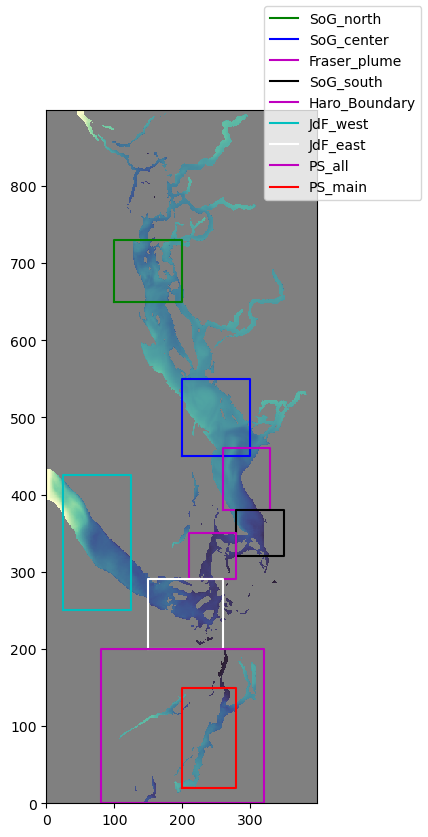

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(ds[name][0], cmap=mycmap)
sa_vi.set_aspect(ax)

SoG_north = [650, 730, 100, 200]
plot_box(ax, SoG_north, 'g')
SoG_center = [450, 550, 200, 300]
plot_box(ax, SoG_center, 'b')
Fraser_plume = [380, 460, 260, 330]
plot_box(ax, Fraser_plume, 'm')
SoG_south = [320, 380, 280, 350]
plot_box(ax, SoG_south, 'k')
Haro_Boundary = [290, 350, 210, 280]
plot_box(ax, Haro_Boundary, 'm')
JdF_west = [250, 425, 25, 125]
plot_box(ax, JdF_west, 'c')
JdF_east = [200, 290, 150, 260]
plot_box(ax, JdF_east, 'w')
PS_all = [0, 200, 80, 320]
plot_box(ax, PS_all, 'm')
PS_main = [20, 150, 200, 280]
plot_box(ax, PS_main, 'r')

boxnames = ['SoG_north','SoG_center','Fraser_plume','SoG_south', 'Haro_Boundary', 'JdF_west', 'JdF_east', 'PS_all', 'PS_main']
fig.legend(boxnames)

boxes = [SoG_north,SoG_center,Fraser_plume,SoG_south,Haro_Boundary,JdF_west,JdF_east,PS_all,PS_main]

regions0 = np.full((len(ds.y),len(ds.x)),np.nan)

for i in range (0, len(boxes)):
    regions0[boxes[i][0]:boxes[i][1], boxes[i][2]:boxes[i][3]] = i

regions0 = xr.DataArray(regions0,dims = ['y','x'])

# # Low resolution
# temp = []

# for i in boxes:
#     temp.append([x//5 for x in i])

# boxes = temp

## Datasets

In [13]:
# Low resolution

# ds = ds.isel(y=(np.arange(ds.y[0], ds.y[-1], 5)), 
#     x=(np.arange(ds.x[0], ds.x[-1], 5)))

# ds2 = ds2.isel(y=(np.arange(ds2.y[0], ds2.y[-1], 5)), 
#     x=(np.arange(ds2.x[0], ds2.x[-1], 5)))

# regions0 = regions0.isel(y=(np.arange(regions0.y[0], regions0.y[-1], 5)), 
#     x=(np.arange(regions0.x[0], regions0.x[-1], 5)))

dataset = ds.sel(time_counter = slice('2007', '2020'))
dataset2 = ds2.sel(time_counter = slice('2007', '2020'))

inputs,targets,indx = datasets_preparation(dataset,dataset2,boxes,regions0,name,inputs_names)

dataset_test = ds.sel(time_counter = slice('2021', '2024'))
dataset2_test = ds2.sel(time_counter = slice('2021', '2024'))

inputs_test,targets_test,indx_test = datasets_preparation(dataset_test,dataset2_test,boxes,regions0,name,inputs_names)


## Bootstrap

In [14]:
n_resamples = 100

r_train = np.full((n_resamples+1, len(boxes)), np.nan)
rms_train = np.full_like(r_train, np.nan)
slope_train = np.full_like(r_train, np.nan)

r_train_season = np.full_like(r_train, np.nan)
slope_train_season = np.full_like(r_train, np.nan)

r_test = np.full_like(r_train, np.nan)
rms_test = np.full_like(r_train, np.nan)
slope_test = np.full_like(r_train, np.nan)

r_test_season = np.full_like(r_train, np.nan)
slope_test_season = np.full_like(r_train, np.nan)

rms_test_s = np.full_like(r_train, np.nan)

predictions,predictions_test,season_train,season_test = train_test(dataset,inputs,targets,dataset_test,inputs_test,targets_test,boxes,lags)
r_train[0],rms_train[0],slope_train[0],r_train_season[0],slope_train_season[0] = metrics_train(targets,predictions,season_train,boxes)
r_test[0],rms_test[0],slope_test[0],r_test_season[0],slope_test_season[0],rms_test_s[0] = metrics_test(targets_test,predictions_test,season_test,boxes)

errors_new = np.zeros(targets.shape)
errors = targets - predictions

for j in tqdm(range (0, n_resamples)):

    temp = resample(errors.transpose(1,0,2))
    errors_new = temp.transpose(1,0,2)
    targets_new = errors_new + predictions

    predictions,predictions_test,season_train,season_test = train_test(dataset,inputs,targets_new,dataset_test,inputs_test,targets_test,boxes,lags)
    r_train[j+1],rms_train[j+1],slope_train[j+1],r_train_season[j+1],slope_train_season[j+1] = metrics_train(targets_new,predictions,season_train,boxes)
    r_test[j+1],rms_test[j+1],slope_test[j+1],r_test_season[j+1],slope_test_season[j+1],rms_test_s[j+1] = metrics_test(targets_test,predictions_test,season_test,boxes)
    

100%|██████████| 100/100 [29:23<00:00, 17.64s/it]


## Histograms

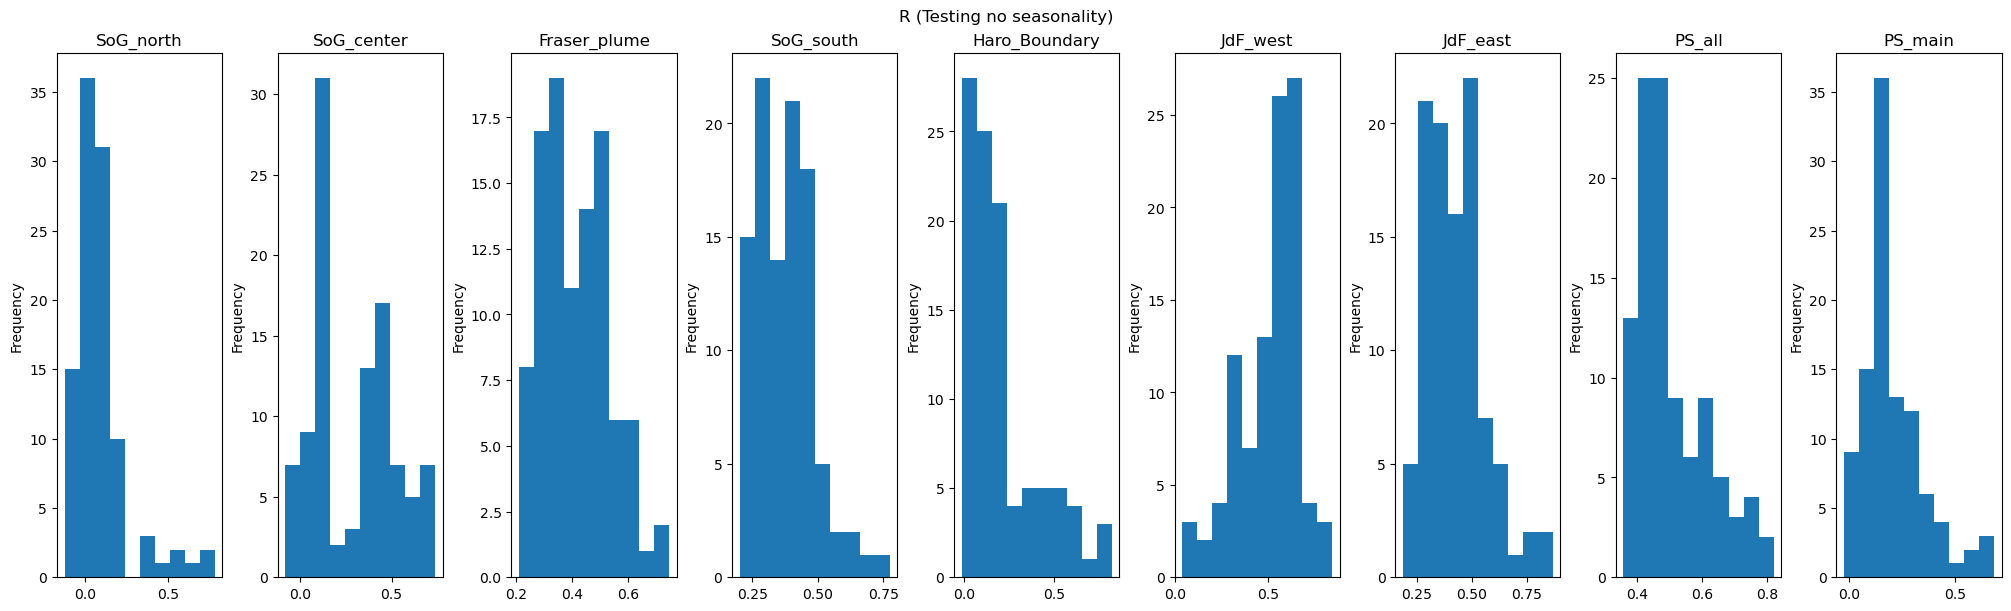

In [19]:
fig, axs = plt.subplots(1,len(boxes), figsize = (20,6), layout='constrained')

for j in range(0,len(boxes)):

    h = axs[j].hist(r_test_season[:,j])
    axs[j].set_title(boxnames[j])

    axs[j].set_ylabel('Frequency')
    fig.suptitle('R (Testing no seasonality)')


## Saving

In [16]:
# path = '/data/ibougoudis/MOAD/files/results/' + name + '/func_reg_boxes_s1_boot/'

# os.makedirs(path, exist_ok=True)

# with open(path + 'train_metrics.pkl', 'wb') as f:
#     dill.dump([r_train,rms_train,slope_train,r_train_season,slope_train_season], f)

# with open(path + 'test_metrics.pkl', 'wb') as f:
#     dill.dump([r_test,rms_test,slope_test,r_test_season,slope_test_season,rms_test_s], f)
